# Apartments Analysis

In this project, we will analyze Apartments for rent in the city of Tel Aviv.        
Our main goals are to try to understand in depth the area of apartment rental in Tel Aviv.   

## Introduction and Background
Finding an apartment for rent is not a simple task. And it is usually necessary to see a large number of apartments 
and be prepared for certain compromises before we can make a decision and enter any apartment.  
For that, we performed in-depth analysis to understand the field in depth.   
Our motivation in choosing a project topic in this area comes from the fact that we find ourselves  
spending a lot of time, each day, for finding apartments for rent. 

## Data acquisition
For the purposes of this project, we will use data collected from ads which have been published on the site Yad2.   
All the information has been collected using a Web crawler.    


### Work through the notebook
First we will import all the relevant dependencies we need.

In [11]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

#### Loading in the data  
Our data is stored and organized in a csv file.  
We'll start reading in the data into pandas dataframes and see some information.  

In [12]:
# Read in the data
apartments = pd.read_csv('apartments.csv')

print(f'Apartments dataset has {apartments.shape[0]} entries with {apartments.shape[1]} variables.')

Apartments dataset has 513 entries with 11 variables.


In [13]:
apartments.head()

,Title,Area,Price,Rooms,Floor,Square-meter,Area-text,Elevator,Air-condition,Refurbished,Furniture
0,חכמי אתונה 48,south,"2,800 ₪",1,1,25,"שפירא, תל אביב יפו",False,True,True,True
1,י.ל. פרץ 38,south,"6,300 ₪",3,5,100,"נווה שאנן, תל אביב יפו",True,True,True,False
2,נווה שאנן,south,"5,700 ₪",3,4,57,"נווה שאנן, תל אביב יפו",True,True,True,False
3,דרך קיבוץ גלויות 113,south,"3,200 ₪",1,קרקע,25,"שפירא, תל אביב יפו",False,True,True,False
4,הקונגרס 3,south,"6,000 ₪",3,קרקע,80,"נווה שאנן, תל אביב יפו",False,True,False,False


### Feature Observation

In [14]:
# Data features
apartments[0:0]

,Title,Area,Price,Rooms,Floor,Square-meter,Area-text,Elevator,Air-condition,Refurbished,Furniture


- **Title**: the actual apartment address
- **Area**: we divided the city into areas north-south-east-west
- **Area-text**: the neighborhood where the apartment is located
- **Price**: price of rent per month in ILS
- **Rooms**: number of rooms in the apartment
- **Floor**: number of floor of the apartment in the building
- **Square-meter**: the size of the apartment space in square meters
- **Elevator/air-condition/refurbished/furniture**: additional parameters that can be exist or not

## Data cleaning

### Handling missing data
Some of the values are missing, they anotated as 'לא צוין'

In [15]:
# Remove missing values
apartments = apartments[apartments['Price'] != 'לא צוין מחיר']
apartments = apartments[apartments['Rooms'] != 'לא צוין']

print(f'Now the dataset has {apartments.shape[0]} entries.')

Now the dataset has 488 entries.


### Handling Data types
Lets look at the variables type

In [16]:
apartments.dtypes

Title            object
Area             object
Price            object
Rooms            object
Floor            object
Square-meter     object
Area-text        object
Elevator           bool
Air-condition      bool
Refurbished        bool
Furniture          bool
dtype: object

We can see that some of the variables are not in the correct type, such as **Price**, **Rooms**, **Floor** so we will need to convert them.

In [17]:
# Convert data types into a valid type
apartments['Price'] = apartments['Price'].apply(lambda s: s.replace(',', '').replace('$', '').replace('₪', '')).astype('float')
apartments['Rooms'] = apartments['Rooms'].astype('float')
apartments.loc[apartments['Floor'] == 'קרקע', 'Floor'] = 0
apartments['Floor'] = apartments['Floor'].astype('int')
apartments.dtypes

Title             object
Area              object
Price            float64
Rooms            float64
Floor              int64
Square-meter      object
Area-text         object
Elevator            bool
Air-condition       bool
Refurbished         bool
Furniture           bool
dtype: object

## Let's explore some of the features

#### Elevator, Air-condition, Refurbished, Furniture
How many apartments do they have and some do not?

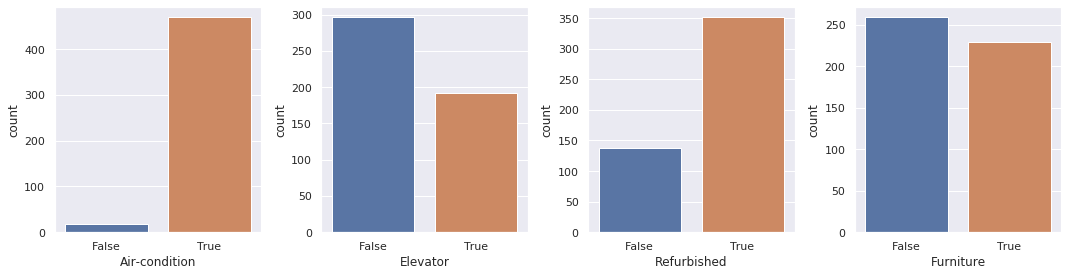

In [18]:
# Plot on the same figure
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(15, 4))

sns.countplot(x='Air-condition', data=apartments, ax=ax1)
sns.countplot(x='Elevator', data=apartments, ax=ax2)
sns.countplot(x='Refurbished', data=apartments, ax=ax3)
sns.countplot(x='Furniture', data=apartments, ax=ax4)

# Fix layout spaces
plt.tight_layout()

Almost all of the apartments have air condition, still .. this is Tel Aviv

### Rooms
The distribution of number of rooms in the apartments

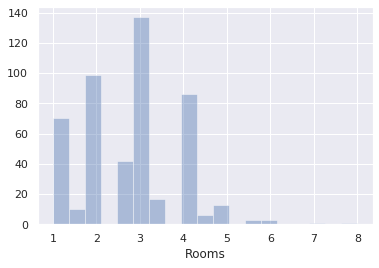

In [19]:
sns.distplot(apartments['Rooms'], kde=False)

We can see that the values are categorical.  
Average number of rooms is 3

### Price
The prices are in ILS (israeli shekels)

count      488.0
mean      7290.0
std       5786.0
min        980.0
25%       4200.0
50%       6000.0
75%       8500.0
max      70000.0
Name: Price, dtype: float64

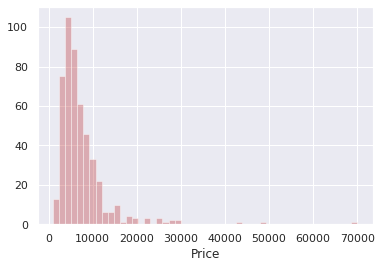

In [20]:
sns.distplot(apartments['Price'], color='r', hist=True, kde=False)

# Price stats
apartments['Price'].describe().round()

## Exploratory Data Analysis

- Generate questions about your data.



- Search for answers by visualising, transforming, and modelling your data.

- Use what you learn to refine your questions and/or generate new questions.